In [1]:
#import dependencies
import numpy as np
import pandas as pd
import os #for file operations
import glob #for file operations
import json #for creating dataset
import random
import time
from datetime import datetime


import storage
import csv

import spacy

import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

### Retrieve & Format Departments (Actors), Articles (Events), Links (Edges)

In [2]:
departments = storage.retrieve_all_departments()
article_dept_links = storage.get_article_department_links()
articles = storage.retrieve_all_articles()

In [3]:
department_frame = pd.DataFrame.from_records(departments, columns =['index', 'name', 'lat', 'long'])
article_frame = pd.DataFrame.from_records(articles, columns =['index', 'title', 'journal', 'date', 'abstract', 'grants'])
link_frame = pd.DataFrame.from_records(article_dept_links, columns =['dept0_index', 'dept1_index', 'article_index', 'journal'])


In [4]:
department_frame.head()

,index,name,lat,long
0,1,"European Molecular Biology Laboratory, Genome ...",49.409136,8.694518
1,2,"European Molecular Biology Laboratory, Structu...",49.409136,8.694518
2,3,"European Molecular Biology Laboratory, Structu...",49.409136,8.694518
3,4,"European Molecular Biology Laboratory, Genome ...",49.409136,8.694518
4,5,"European Molecular Biology Laboratory, Structu...",49.409136,8.694518


In [5]:
article_frame.head()

,index,title,journal,date,abstract,grants
0,1,Emergence of community behaviors in the gut mi...,Cell,2024 Sep 19,Pharmaceuticals can directly inhibit the growt...,
1,2,Microbial transformation of dietary xenobiotic...,Cell,2024 Sep 19,Diet is a major determinant of gut microbiome ...,
2,3,Lightinduced remodeling of phytochrome B enabl...,Cell,2024 Sep 16,Phytochrome B (phyB) and phytochromeinteractin...,
3,4,Profound cellular defects attribute to muscula...,Cell,2024 Sep 13,Duchenne muscular dystrophy (DMD) is a progres...,
4,5,m(6)Amodified cenRNA stabilizes CENPA to ensur...,Cell,2024 Sep 18,m(6)A modification is best known for its criti...,


In [6]:
link_frame.head()

,dept0_index,dept1_index,article_index,journal
0,1,2,1,Cell
1,1,3,1,Cell
2,1,4,1,Cell
3,1,5,1,Cell
4,1,6,1,Cell


#### Format Time

In [7]:
article_frame.fillna("--",inplace=True)
article_frame['date']= article_frame['date'].apply(lambda d: d.replace("--","1900 Jan 0"))
article_frame['date'] = article_frame['date'].apply(lambda d: " ".join(d.split(" ")[0:2]))
article_frame['date'] = article_frame['date'].apply(lambda d: datetime.strptime(d, '%Y %b'))
article_frame['date'] = article_frame['date'] = pd.to_datetime(article_frame['date'], format="%m/%d/%Y")


In [8]:
article_frame['date'].describe()

count                             1650
mean     2020-02-23 15:06:45.818181632
min                1900-01-01 00:00:00
25%                2023-12-01 00:00:00
50%                2024-05-01 00:00:00
75%                2024-08-01 00:00:00
max                2024-10-01 00:00:00
Name: date, dtype: object

#### Descriptions of Dataframes Prior to Filtering + Processing

In [9]:
department_frame.describe()

,index,lat,long
count,13451.00000,13451.000000,13451.000000
mean,6726.00000,32.366588,-6.331001
std,3883.11357,24.022522,76.300910
min,1.00000,-45.874098,-157.861540
25%,3363.50000,30.580944,-76.605221
50%,6726.00000,39.906217,0.000000
75%,10088.50000,47.822035,31.045686
max,13451.00000,64.997588,178.442814


In [10]:
article_frame.describe()

,index,date
count,1650.000000,1650
mean,825.500000,2020-02-23 15:06:45.818181632
min,1.000000,1900-01-01 00:00:00
25%,413.250000,2023-12-01 00:00:00
50%,825.500000,2024-05-01 00:00:00
75%,1237.750000,2024-08-01 00:00:00
max,1650.000000,2024-10-01 00:00:00
std,476.458288,NaN


In [11]:
link_frame.describe()

,dept0_index,dept1_index,article_index
count,251408.000000,251408.000000,251408.000000
mean,6541.272279,6541.272279,762.464345
std,3742.038375,3742.038375,463.413282
min,1.000000,1.000000,1.000000
25%,3462.750000,3462.750000,414.000000
50%,6380.000000,6380.000000,668.000000
75%,9637.000000,9637.000000,1135.000000
max,13451.000000,13451.000000,1650.000000


### Filter Publications without American Presence

In [12]:
# Load the GeoJSON file containing the country boundaries
geojson_path = 'worldcountries.geojson'
world = gpd.read_file(geojson_path)

# Check the column name for the United States boundary
us_boundary = world[world['COUNTRY'] == 'United States']

# Step 1: Filter out departments with (0, 0) latitude and longitude
department_frame_filtered = department_frame[(department_frame['lat'] != 0) & (department_frame['long'] != 0)].copy()

# Step 2: Convert the department coordinates (lat, long) into geometry objects for the filtered dataframe
department_frame_filtered['geometry'] = department_frame_filtered.apply(lambda row: Point(row['long'], row['lat']), axis=1)

# Convert the filtered department_frame to a GeoDataFrame
gdf_departments = gpd.GeoDataFrame(department_frame_filtered, geometry='geometry')

# Step 3: Use the `unary_union` property to get the U.S. boundary
us_boundary_union = us_boundary.geometry.unary_union  # Access the union of geometries
departments_in_us = gdf_departments[gdf_departments.within(us_boundary_union)]

# Extract the indices of departments in the U.S.
us_department_indices = set(departments_in_us['index'].tolist())

# Step 4: Filter the link_frame (now referred to as link_frame)
# Identify all article indices where at least one department is in the U.S.
us_articles = link_frame[
    (link_frame['dept0_index'].isin(us_department_indices)) | 
    (link_frame['dept1_index'].isin(us_department_indices))
]['article_index'].unique()

# Step 5: Filter the link_frame to retain only articles with at least one U.S. department
filtered_link_frame = link_frame[link_frame['article_index'].isin(us_articles)].copy()

# Step 6: Filter the article_frame to retain only articles linked to U.S. departments
filtered_article_frame = article_frame[article_frame['index'].isin(us_articles)].copy()

# Step 7: Optionally, filter department_frame to reflect only those departments that are in the U.S.
filtered_department_frame = department_frame_filtered[department_frame_filtered['index'].isin(us_department_indices)].copy()

/tmp/ipykernel_18600/842872762.py:18: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  us_boundary_union = us_boundary.geometry.unary_union  # Access the union of geometries


In [13]:
filtered_department_frame.head()

,index,name,lat,long,geometry
13,14,Department of Microbial Pathogenesis and Micro...,41.306065,-72.925770,POINT (-72.92577 41.306065)
14,15,Department of Microbial Pathogenesis and Micro...,41.306065,-72.925770,POINT (-72.92577 41.306065)
15,16,Department of Microbial Pathogenesis and Micro...,41.306065,-72.925770,POINT (-72.92577 41.306065)
16,17,Department of Microbial Pathogenesis and Micro...,41.306065,-72.925770,POINT (-72.92577 41.306065)
44,45,"MOE Key Laboratory of Bioinformatics, Center f...",34.102660,-85.534429,POINT (-85.534429 34.10266)


In [14]:
filtered_article_frame.head()

,index,title,journal,date,abstract,grants
1,2,Microbial transformation of dietary xenobiotic...,Cell,2024-09-01,Diet is a major determinant of gut microbiome ...,
4,5,m(6)Amodified cenRNA stabilizes CENPA to ensur...,Cell,2024-09-01,m(6)A modification is best known for its criti...,
5,6,Nothing about us without us: Sharing results w...,Cell,2024-09-01,Sharing genetic and other study results with t...,
6,7,A transmitochondrial sodium gradient controls ...,Cell,2024-09-01,Eukaryotic cell function and survival rely on ...,
8,9,Genetic tracing of market wildlife and viruses...,Cell,2024-09-01,Zoonotic spillovers of viruses have occurred t...,


In [15]:
filtered_link_frame.head()

,dept0_index,dept1_index,article_index,journal
156,14,15,2,Cell
157,14,16,2,Cell
158,14,17,2,Cell
159,15,14,2,Cell
160,15,16,2,Cell


#### Descriptions of Dataframes After to Filtering 

In [16]:
filtered_department_frame.describe()

,index,lat,long
count,3971.000000,3971.000000,3971.000000
mean,6548.736338,38.844906,-88.914980
std,3895.607053,4.515342,18.551934
min,14.000000,19.705506,-155.080147
25%,2958.500000,35.913147,-96.840285
50%,6318.000000,39.289642,-81.126935
75%,9869.500000,42.347527,-75.166855
max,13451.000000,48.588928,-70.198841


In [17]:
filtered_article_frame.describe()

,index,date
count,599.000000,599
mean,770.821369,2024-03-25 07:24:44.474123520
min,2.000000,2023-01-01 00:00:00
25%,349.000000,2023-12-01 00:00:00
50%,740.000000,2024-05-01 00:00:00
75%,1184.500000,2024-08-01 00:00:00
max,1650.000000,2024-10-01 00:00:00
std,483.587765,NaN


In [18]:
filtered_link_frame.describe()

,dept0_index,dept1_index,article_index
count,180624.000000,180624.000000,180624.000000
mean,6290.452775,6290.452775,728.287780
std,3644.543581,3644.543581,450.067243
min,14.000000,14.000000,2.000000
25%,3179.000000,3179.000000,379.000000
50%,6065.000000,6065.000000,638.000000
75%,9455.000000,9455.000000,1126.000000
max,13451.000000,13451.000000,1650.000000


In [19]:
print("Before filtering: ")
print(str(len(article_frame))+" events and "+str(len(department_frame))+" actors")
print("After filtering: ")
print(str(len(filtered_article_frame))+" events and "+str(len(filtered_department_frame))+" actors")
geo_good = department_frame[(department_frame['lat'] != 0) & (department_frame['long'] != 0)]
geo_bad = department_frame[(department_frame['lat'] == 0) & (department_frame['long'] == 0)].copy()
print("Of all departments, "+ str(len(geo_bad)) + " had malformed geolocation information")

Before filtering: 
1650 events and 13451 actors
After filtering: 
599 events and 3971 actors
Of all departments, 148 had malformed geolocation information


In [20]:
geo_bad.head()

,index,name,lat,long
142,143,"HIV Mental Health Research Unit, Division of N...",0.0,0.0
662,663,Key Laboratory of Organ Regeneration and Recon...,0.0,0.0
665,666,Key Laboratory of Organ Regeneration and Recon...,0.0,0.0
666,667,Key Laboratory of Organ Regeneration and Recon...,0.0,0.0
669,670,Key Laboratory of Organ Regeneration and Recon...,0.0,0.0


In [21]:
print(geo_bad['name'].iloc[0])
print(" - ")
print(geo_bad['name'].iloc[1])

HIV Mental Health Research Unit, Division of Neuropsychiatry, Department of Psychiatry and Mental Health, Neuroscience Institute, University of Cape Town, Cape Town, South Africa. 
 - 
Key Laboratory of Organ Regeneration and Reconstruction, State Key Laboratory of Membrane Biology, State Key Laboratory of Stem Cell and Reproductive Biology, Institute of Zoology, Chinese Academy of Sciences, Beijing 100101, China


Try extracting a location as an entity before passing it to the MapBox

## Building An Affiliation Network

The first step of creating the affiliation network is standardizing the varied university and organization names - linking them to a set, so that \['Department of Chemistry, Princeton U', 'Department of Neuroscience, Princeton University'\] both resolve to 'Princeton University'. 


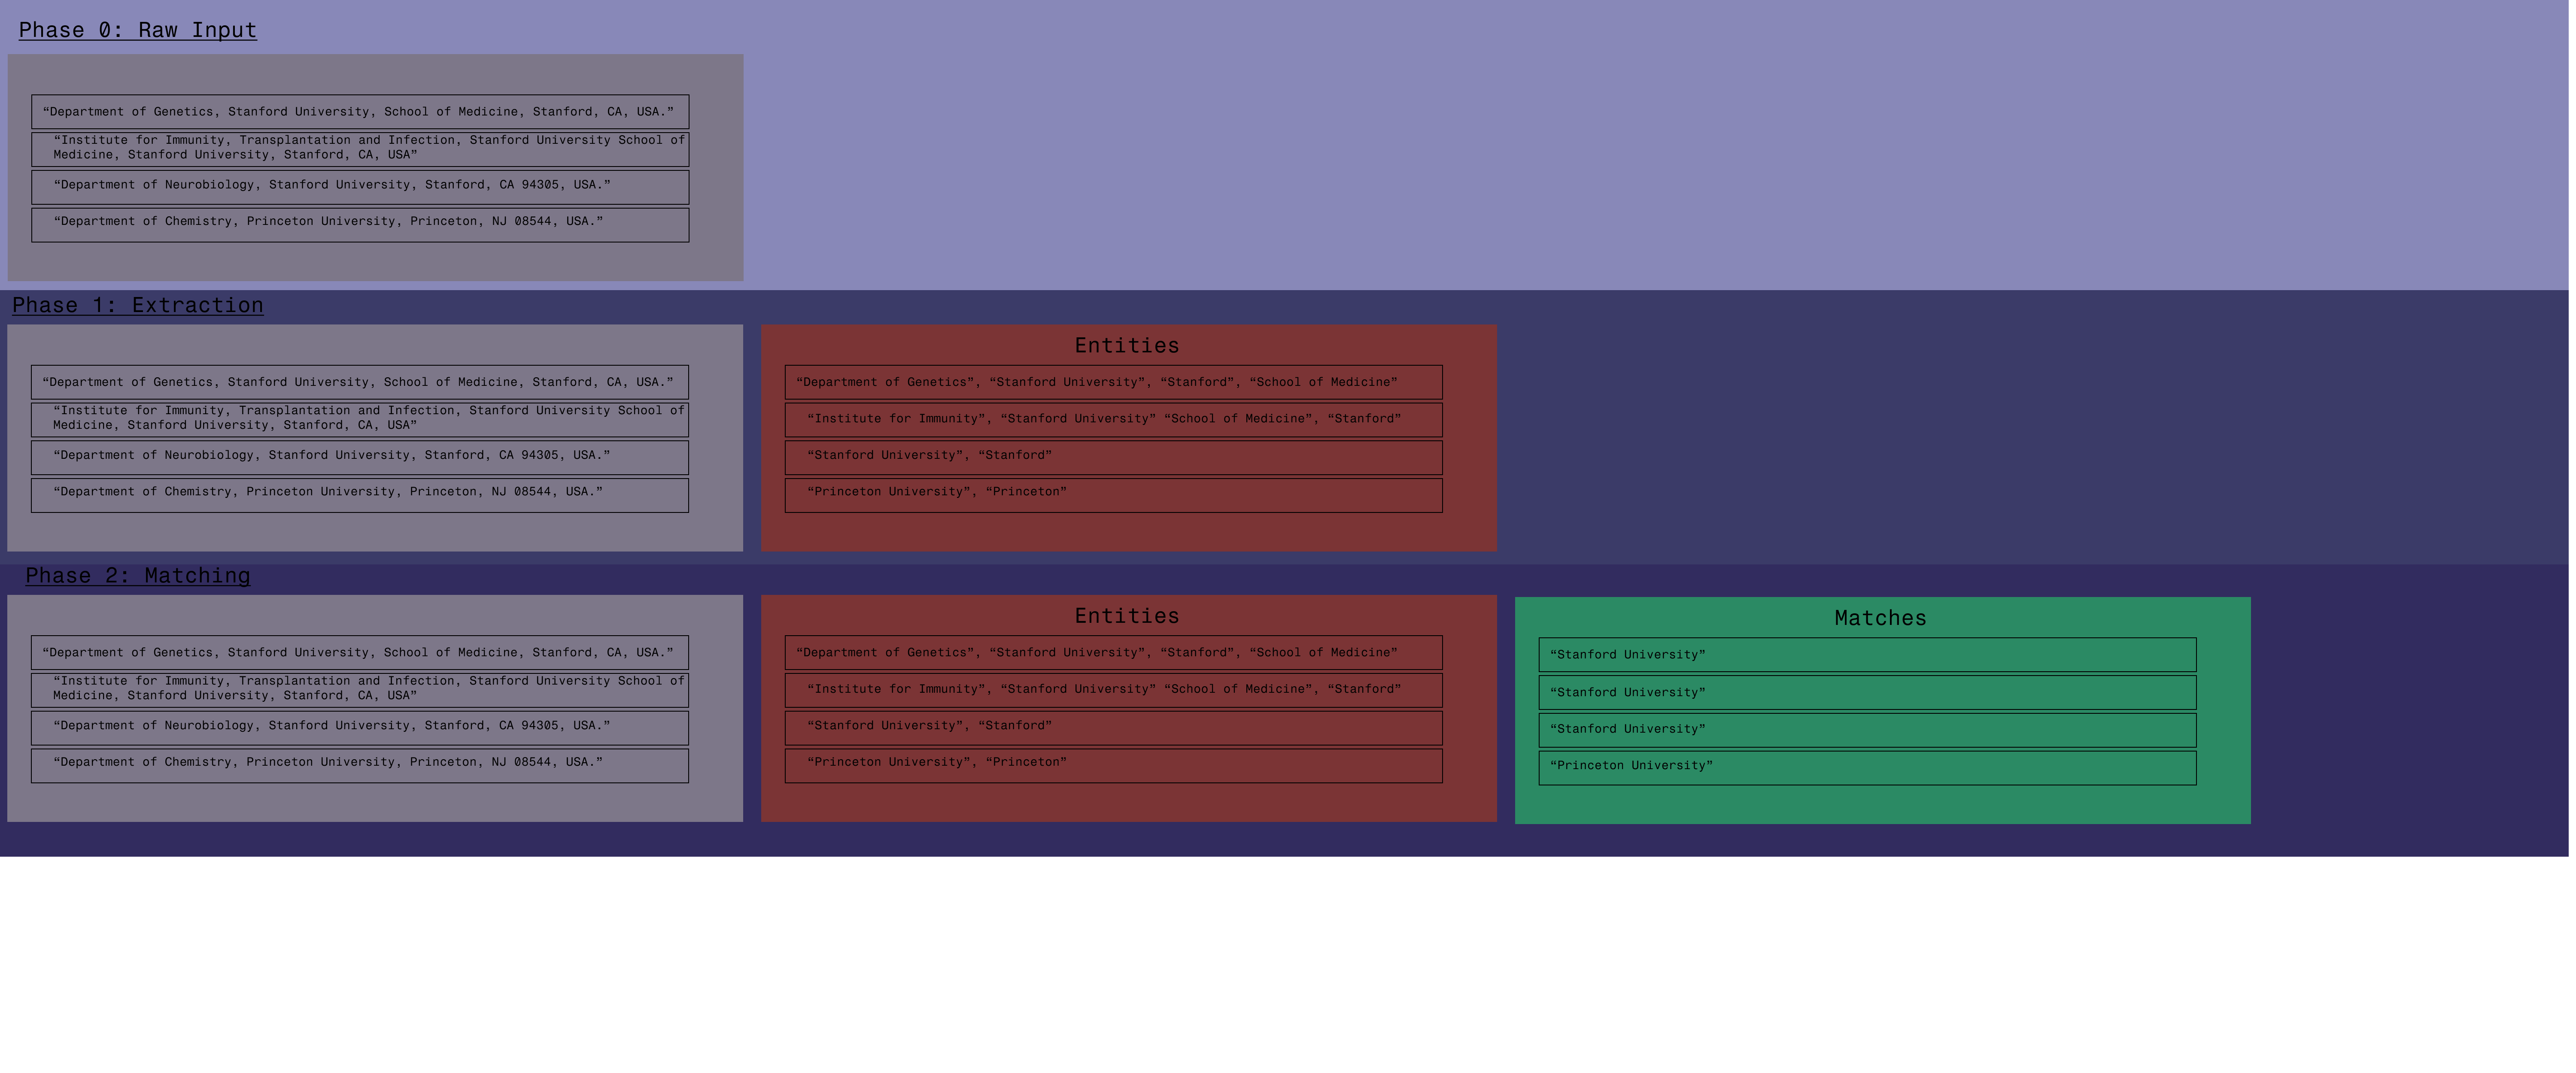

In [22]:
from IPython.display import Image
Image(filename='phases.png') 

## GliNER

[GLiNER: Generalist Model for Named Entity Recognition using Bidirectional Transformer by Zaratiana et. al](https://arxiv.org/pdf/2311.08526) presents an open named entity resolution model which matches text to a set of natural language entity tags provided at inference time. 

In [23]:
#Load Spacy+Gliner Pipeline Pipeline
nlp = spacy.blank("en")
#add configs (University, School, Organization)
custom_spacy_config = { "gliner_model": "urchade/gliner_multi",
                            "chunk_size": 250,
                            "labels": ["university", "school", "organization"],
                            "style": "ent"}
nlp.add_pipe("gliner_spacy", config=custom_spacy_config)

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

/home/aidan/.local/lib/python3.12/site-packages/transformers/convert_slow_tokenizer.py:560: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
/home/aidan/.local/lib/python3.12/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [24]:
texts = geo_good['name'].to_list()


In [25]:
tagged_schools = []
for doc in nlp.pipe(texts, disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer"]):
    ents_schools = [ent.text for ent in doc.ents if ent.label_ == 'university' or ent.label_ == 'school']
    #if university or school is identified, append to the list
    if(len(ents_schools) >= 1):
        tagged_schools.append(ents_schools)
    #if a university or school is not identified, look for organizations
    else:
        ents_orgs = [ent.text for ent in doc.ents if ent.label_ == 'organization']
        if(len(ents_orgs)>=1):
            tagged_schools.append(ents_orgs)
    #this should just append the actual text itself if no entities are extracted
    # - if a department entity is included it will use that first
    if(len(ents_schools) == 0 and len(ents_orgs) == 0):
        ents_orgs = [ent.text for ent in doc.ents if ent.label_ == 'department']
        if(len(ents_orgs) != 0):
            tagged_schools.append(ents_orgs)
        elif (len(ents_orgs) == 0):
            tagged_schools.append([doc.text])


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [26]:
print(tagged_schools)

[['European Molecular Biology Laboratory', 'Genome Biology'], ['European Molecular Biology Laboratory', 'Structural and Computational Biology'], ['European Molecular Biology Laboratory', 'Structural and Computational Biology'], ['European Molecular Biology Laboratory', 'Genome Biology'], ['European Molecular Biology Laboratory', 'Structural and Computational Biology'], ['European Molecular Biology Laboratory', 'Genome Biology'], ['European Molecular Biology Laboratory', 'Structural and Computational Biology'], ['European Molecular Biology Laboratory', 'Genome Biology'], ['European Molecular Biology Laboratory', 'Genome Biology'], ['European Molecular Biology Laboratory', 'Structural and Computational Biology'], ['European Molecular Biology Laboratory', 'Structural and Computational Biology'], ['European Molecular Biology Laboratory', 'Structural and Computational Biology'], ['European Molecular Biology Laboratory', 'Genome Biology'], ['Yale University'], ['Yale University'], ['Yale Uni

In [27]:
from relik import Relik
from relik.inference.data.objects import RelikOutput

relik = Relik.from_pretrained("sapienzanlp/relik-entity-linking-large")


                ___              __         
               /\_ \      __    /\ \        
 _ __     __   \//\ \    /\_\   \ \ \/'\    
/\`'__\ /'__`\   \ \ \   \/\ \   \ \ , <    
\ \ \/ /\  __/    \_\ \_  \ \ \   \ \ \\`\  
 \ \_\ \ \____\   /\____\  \ \_\   \ \_\ \_\
  \/_/  \/____/   \/____/   \/_/    \/_/\/_/
                                            
                                            



/home/aidan/.local/lib/python3.12/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


[2024-10-24 15:27:52,502] [INFO] [relik.inference.annotator.from_pretrained:700] [PID:18600] [RANK:0] Loading Relik from sapienzanlp/relik-entity-linking-large
[2024-10-24 15:27:52,503] [INFO] [relik.inference.annotator.from_pretrained:701] [PID:18600] [RANK:0] {
    '_target_': 'relik.inference.annotator.Relik',
    'index': {
        'span': {
            '_target_': 'relik.retriever.indexers.inmemory.InMemoryDocumentIndex.from_pretrained',
            'name_or_path': 'sapienzanlp/relik-retriever-e5-base-v2-aida-blink-wikipedia-index',
        },
    },
    'metadata_fields': [],
    'reader': {
        '_target_': 'relik.reader.pytorch_modules.span.RelikReaderForSpanExtraction',
        'transformer_model': 'sapienzanlp/relik-reader-deberta-v3-large-aida',
        'use_nme': True,
    },
    'retriever': {
        'span': {
            '_target_': 'relik.retriever.pytorch_modules.model.GoldenRetriever',
            'question_encoder': 'sapienzanlp/relik-retriever-e5-base-v2-aida-bli

In [28]:
RelikOutput = relik("Tsinghua University was one of the universities in the world.")


[2024-10-24 15:28:55,274] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:18600] [RANK:0] Dataset finished: 1 number of elements processed


In [29]:
print(dir(RelikOutput.candidates))


['__add__', '__annotations__', '__class__', '__class_getitem__', '__contains__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getnewargs__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__match_args__', '__module__', '__mul__', '__ne__', '__new__', '__orig_bases__', '__reduce__', '__reduce_ex__', '__repr__', '__rmul__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '_asdict', '_field_defaults', '_fields', '_make', '_replace', 'count', 'index', 'span', 'triplet']


In [30]:
print(len(RelikOutput.candidates.span))

1


In [31]:
print((RelikOutput.candidates.span[len(RelikOutput.candidates.span)-1]))

[[{"text": "Tsinghua University", "id": 5902060, "metadata": {"definition": "Tsinghua University (abbreviated THU; ; also romanized as Qinghua) is a major research university in Beijing, and a member of the elite C9 League of Chinese universities. Since its establishment in 1911, it has graduated numerous Chinese leaders in politics, business, academia, and culture.  Reflecting its motto of \"Self-Discipline and Social Commitment\", Tsinghua University is dedicated to academic excellence, advancing the well-being of Chinese society, and global development. Tsinghua is perennially ranked as one of the top academic institutions in China, Asia, and worldwide, and was recognized as the 14th best university in the 2017 Times Higher Education World Reputation Rankings. Since 2015, Tsinghua has been ranked as the best engineering and computer science school in the world based on factors including total research output and performance. Tsinghua is a Class A institution in the Double First Clas

In [32]:
print(type(RelikOutput.candidates.span[len(RelikOutput.candidates.span)-1]))

<class 'list'>


In [33]:
print(type(RelikOutput.candidates.span[len(RelikOutput.candidates.span)-1][0]))

<class 'list'>


In [34]:
print((RelikOutput.candidates.span[0][0][0]))
print(type(RelikOutput.candidates.span[0][0][0]))
print(dir(RelikOutput.candidates.span[0][0][0]))
print((RelikOutput.candidates.span[0][0][0].id))
print((RelikOutput.candidates.span[0][0][0].text))

5902060:Tsinghua University
<class 'relik.retriever.indexers.document.Document'>
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'from_dict', 'from_file', 'id', 'metadata', 'save', 'text', 'to_dict', 'to_json']
5902060
Tsinghua University


In [35]:
RelikOutput.candidates.span[0][0][0].id
RelikOutput.candidates.span[0][0][0].text

'Tsinghua University'

## [ReLik](https://arxiv.org/pdf/2408.00103)

In [39]:
match_tagged = []
exception_count = 0
for i in range(0, len(tagged_schools)):
    try:
        RelikOutput = relik(tagged_schools[i][0])
        id_r = RelikOutput.candidates.span[0][0][0].id
        tx_r = RelikOutput.candidates.span[0][0][0].text
        linkedE = {"entityID": id_r, "entityText": tx_r}
        match_tagged.append(linkedE)
    except Exception as e:
        if(len(tagged_schools[i])!=0):
            linkedE = {"entityID": "NAN", "entityText": tagged_schools[i][0]}
            match_tagged.append(linkedE)
            exception_count+=1
        else:
            linkedE = {"entityID": "NAN", "entityText": "NAN"}
            match_tagged.append(linkedE)
            exception_count+=1


    

[2024-10-24 15:32:40,653] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:18600] [RANK:0] Dataset finished: 1 number of elements processed
[2024-10-24 15:32:43,891] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:18600] [RANK:0] Dataset finished: 1 number of elements processed
[2024-10-24 15:32:47,240] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:18600] [RANK:0] Dataset finished: 1 number of elements processed
[2024-10-24 15:32:50,496] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:18600] [RANK:0] Dataset finished: 1 number of elements processed
[2024-10-24 15:32:53,821] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:18600] [RANK:0] Dataset finished: 1 number of elements processed
[2024-10-24 15:32:56,983] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:18600] [RANK:0] Dataset finished: 1 number of elements processed
[2024-10-24 15:33:00,200] [DEBUG] [relik.reader.data.relik_reader_data

[2024-10-24 15:35:34,531] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:18600] [RANK:0] Dataset finished: 1 number of elements processed
[2024-10-24 15:35:38,023] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:18600] [RANK:0] Dataset finished: 1 number of elements processed
[2024-10-24 15:35:41,148] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:18600] [RANK:0] Dataset finished: 1 number of elements processed
[2024-10-24 15:35:44,342] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:18600] [RANK:0] Dataset finished: 1 number of elements processed
[2024-10-24 15:35:47,480] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:18600] [RANK:0] Dataset finished: 1 number of elements processed
[2024-10-24 15:35:50,830] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:18600] [RANK:0] Dataset finished: 1 number of elements processed
[2024-10-24 15:35:54,479] [DEBUG] [relik.reader.data.relik_reader_data

[2024-10-24 15:38:22,776] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:18600] [RANK:0] Dataset finished: 1 number of elements processed
[2024-10-24 15:38:25,872] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:18600] [RANK:0] Dataset finished: 1 number of elements processed
[2024-10-24 15:38:29,141] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:18600] [RANK:0] Dataset finished: 1 number of elements processed
[2024-10-24 15:38:32,238] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:18600] [RANK:0] Dataset finished: 1 number of elements processed
[2024-10-24 15:38:35,678] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:18600] [RANK:0] Dataset finished: 1 number of elements processed
[2024-10-24 15:38:39,071] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:18600] [RANK:0] Dataset finished: 1 number of elements processed
[2024-10-24 15:38:41,856] [DEBUG] [relik.reader.data.relik_reader_data

[2024-10-24 15:41:16,320] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:18600] [RANK:0] Dataset finished: 1 number of elements processed
[2024-10-24 15:41:19,569] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:18600] [RANK:0] Dataset finished: 1 number of elements processed
[2024-10-24 15:41:22,964] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:18600] [RANK:0] Dataset finished: 1 number of elements processed
[2024-10-24 15:41:26,536] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:18600] [RANK:0] Dataset finished: 1 number of elements processed
[2024-10-24 15:41:29,570] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:18600] [RANK:0] Dataset finished: 1 number of elements processed
[2024-10-24 15:41:32,733] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:18600] [RANK:0] Dataset finished: 1 number of elements processed
[2024-10-24 15:41:35,820] [DEBUG] [relik.reader.data.relik_reader_data

[2024-10-24 15:44:13,865] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:18600] [RANK:0] Dataset finished: 1 number of elements processed
[2024-10-24 15:44:17,322] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:18600] [RANK:0] Dataset finished: 1 number of elements processed
[2024-10-24 15:44:20,626] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:18600] [RANK:0] Dataset finished: 1 number of elements processed
[2024-10-24 15:44:24,066] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:18600] [RANK:0] Dataset finished: 1 number of elements processed
[2024-10-24 15:44:27,487] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:18600] [RANK:0] Dataset finished: 1 number of elements processed
[2024-10-24 15:44:30,914] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:18600] [RANK:0] Dataset finished: 1 number of elements processed
[2024-10-24 15:44:34,315] [DEBUG] [relik.reader.data.relik_reader_data

[2024-10-24 15:47:12,540] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:18600] [RANK:0] Dataset finished: 1 number of elements processed
[2024-10-24 15:47:15,652] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:18600] [RANK:0] Dataset finished: 1 number of elements processed
[2024-10-24 15:47:19,142] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:18600] [RANK:0] Dataset finished: 1 number of elements processed
[2024-10-24 15:47:22,500] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:18600] [RANK:0] Dataset finished: 1 number of elements processed
[2024-10-24 15:47:26,080] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:18600] [RANK:0] Dataset finished: 1 number of elements processed
[2024-10-24 15:47:29,498] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:18600] [RANK:0] Dataset finished: 1 number of elements processed
[2024-10-24 15:47:32,803] [DEBUG] [relik.reader.data.relik_reader_data

[2024-10-24 15:50:03,937] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:18600] [RANK:0] Dataset finished: 1 number of elements processed
[2024-10-24 15:50:07,322] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:18600] [RANK:0] Dataset finished: 1 number of elements processed
[2024-10-24 15:50:10,685] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:18600] [RANK:0] Dataset finished: 1 number of elements processed
[2024-10-24 15:50:14,121] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:18600] [RANK:0] Dataset finished: 1 number of elements processed
[2024-10-24 15:50:17,531] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:18600] [RANK:0] Dataset finished: 1 number of elements processed
[2024-10-24 15:50:20,934] [DEBUG] [relik.reader.data.relik_reader_data.__iter__:527] [PID:18600] [RANK:0] Dataset finished: 1 number of elements processed
[2024-10-24 15:50:24,447] [DEBUG] [relik.reader.data.relik_reader_data

KeyboardInterrupt: 

In [40]:
print(match_tagged)

[{'entityID': 3562459, 'entityText': 'European Molecular Biology Laboratory'}, {'entityID': 3562459, 'entityText': 'European Molecular Biology Laboratory'}, {'entityID': 3562459, 'entityText': 'European Molecular Biology Laboratory'}, {'entityID': 3562459, 'entityText': 'European Molecular Biology Laboratory'}, {'entityID': 3562459, 'entityText': 'European Molecular Biology Laboratory'}, {'entityID': 3562459, 'entityText': 'European Molecular Biology Laboratory'}, {'entityID': 3562459, 'entityText': 'European Molecular Biology Laboratory'}, {'entityID': 3562459, 'entityText': 'European Molecular Biology Laboratory'}, {'entityID': 3562459, 'entityText': 'European Molecular Biology Laboratory'}, {'entityID': 3562459, 'entityText': 'European Molecular Biology Laboratory'}, {'entityID': 3562459, 'entityText': 'European Molecular Biology Laboratory'}, {'entityID': 3562459, 'entityText': 'European Molecular Biology Laboratory'}, {'entityID': 3562459, 'entityText': 'European Molecular Biology

In [41]:
df3 = pd.json_normalize(match_tagged) 

In [42]:
df3.head()

,entityID,entityText
0,3562459,European Molecular Biology Laboratory
1,3562459,European Molecular Biology Laboratory
2,3562459,European Molecular Biology Laboratory
3,3562459,European Molecular Biology Laboratory
4,3562459,European Molecular Biology Laboratory


In [43]:
df3.describe()

,entityID
count,3.470000e+02
mean,2.802357e+06
std,1.669795e+06
min,5.595500e+04
25%,1.181328e+06
50%,2.997078e+06
75%,4.051166e+06
max,5.900813e+06


In [44]:
df3['entityText'].describe()

count                           347
unique                          117
top       Regeneron Pharmaceuticals
freq                             19
Name: entityText, dtype: object

In [ ]:
df3['entityText'].describe()

In [45]:
df4 = pd.concat([geo_good, df3], axis=1)


In [46]:
df4.head()

,index,name,lat,long,entityID,entityText
0,1.0,"European Molecular Biology Laboratory, Genome ...",49.409136,8.694518,3562459.0,European Molecular Biology Laboratory
1,2.0,"European Molecular Biology Laboratory, Structu...",49.409136,8.694518,3562459.0,European Molecular Biology Laboratory
2,3.0,"European Molecular Biology Laboratory, Structu...",49.409136,8.694518,3562459.0,European Molecular Biology Laboratory
3,4.0,"European Molecular Biology Laboratory, Genome ...",49.409136,8.694518,3562459.0,European Molecular Biology Laboratory
4,5.0,"European Molecular Biology Laboratory, Structu...",49.409136,8.694518,3562459.0,European Molecular Biology Laboratory


In [48]:
df4.describe()

,index,lat,long,entityID
count,13303.000000,13303.000000,13303.000000,3.470000e+02
mean,6717.716756,32.726676,-6.401435,2.802357e+06
std,3881.702411,23.910602,76.721265,1.669795e+06
min,1.000000,-45.874098,-157.861540,5.595500e+04
25%,3359.500000,31.232276,-76.612300,1.181328e+06
50%,6700.000000,39.952755,-0.008160,2.997078e+06
75%,10073.500000,48.025005,31.089823,4.051166e+06
max,13451.000000,64.997588,178.442814,5.900813e+06


## BLINK [NOT CONTEMPORARY]

[Multilingual Autoregressive Entity Linking](https://arxiv.org/pdf/2103.12528) presents a Wikipedia-grounded entity resolution model. 

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("facebook/genre-linking-blink")
model = AutoModelForSeq2SeqLM.from_pretrained("facebook/genre-linking-blink").eval()


In [ ]:
print(tagged_schools[0][0])
outputs = model.generate(
    **tokenizer(tagged_schools[0][0], return_tensors="pt"),
    num_beams=5,
    num_return_sequences=5,
    # OPTIONAL: use constrained beam search
    # prefix_allowed_tokens_fn=lambda batch_id, sent: trie.get(sent.tolist()),
)

tokenizer.batch_decode(outputs, skip_special_tokens=True)

In [ ]:
print(tagged_schools[1][0])
outputs = model.generate(
    **tokenizer(tagged_schools[1][0], return_tensors="pt"),
    num_beams=5,
    num_return_sequences=5,
    # OPTIONAL: use constrained beam search
    # prefix_allowed_tokens_fn=lambda batch_id, sent: trie.get(sent.tolist()),
)

tokenizer.batch_decode(outputs, skip_special_tokens=True)

In [ ]:
print(tagged_schools[153][0])
outputs = model.generate(
    **tokenizer(tagged_schools[153][0], return_tensors="pt"),
    num_beams=5,
    num_return_sequences=5,
    # OPTIONAL: use constrained beam search
    # prefix_allowed_tokens_fn=lambda batch_id, sent: trie.get(sent.tolist()),
)

tokenizer.batch_decode(outputs, skip_special_tokens=True)

In [ ]:
print(tagged_schools[0][1])
outputs = model.generate(
    **tokenizer(tagged_schools[0][1], return_tensors="pt"),
    num_beams=5,
    num_return_sequences=5,
    # OPTIONAL: use constrained beam search
    # prefix_allowed_tokens_fn=lambda batch_id, sent: trie.get(sent.tolist()),
)

tokenizer.batch_decode(outputs, skip_special_tokens=True)

## Tuning *AnyMatch* [NOT WORTH IT]

[*AnyMatch – Efficient Zero-Shot Entity Matching
with a Small Language Model* by Zhang et. al](https://arxiv.org/pdf/2409.04073) introduces the *AnyMatch* model. *AnyMatch* is a zero-shot entity matching model, meaning it is capable of accurately matching hitherto unseen examples. This is critical for our usecase as it is not feasible to create a complete dataset of every research organization. *AnyMatch* boasts only a 4.4% reduction in F1 score as compared to  than the score of the state-of-the-art method MatchGPT.